# Tyre Quality Classification

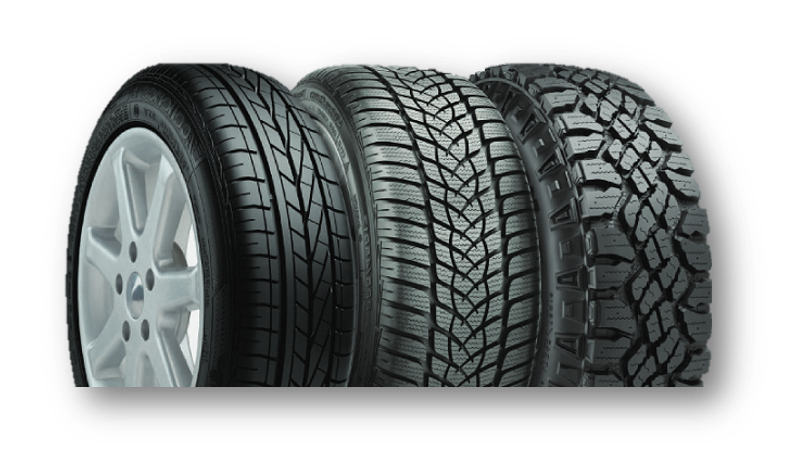

## Libraries & drive settings

In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report
import cv2
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import pathlib
import os
from google.colab import drive
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

## Preprocessing & loading (train and validation set)

In [ ]:
image_directory = "/content/drive/MyDrive/Tyre Quality Classification/data"

# Preprocessing

batch_size = 32
img_width = 224
img_height = 224

# Training data

train_data = tf.keras.utils.image_dataset_from_directory(image_directory,
                                                         validation_split=0.2,
                                                         seed=123,
                                                         subset="training",
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

Found 1866 files belonging to 2 classes.
Using 1493 files for training.


In [ ]:
# Validation data

val_data = tf.keras.utils.image_dataset_from_directory(image_directory,
                                                       validation_split=0.2,
                                                       seed=123,
                                                       subset="validation",
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 1866 files belonging to 2 classes.
Using 373 files for validation.


In [ ]:
class_names = train_data.class_names
print(class_names)

['defective', 'good']


## Analysis

This dataset contains **1866 digital images** of tires categorized into two groups: **defective** and **in good condition**. Each image represents the state of a tire, labeled accordingly as either defective or in good condition. Each one is filed in its own folder.

The primary objective of this notebook is to build models that can predict the quality of tires based on input images. Various machine learning techniques will be explored and implemented to **improve the classification of tire conditions**.

By accurately identifying defective tyres, the model can contribute to **improved safety measures** in the automotive industry.

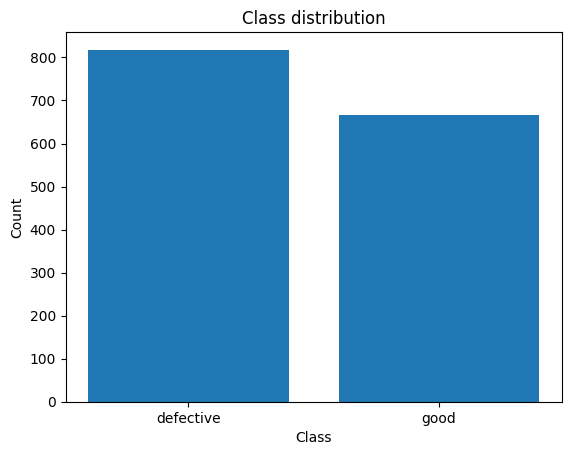

In [ ]:
# Explore class distribution

class_count = {class_name: 0 for class_name in class_names}
for _, labels in train_data:
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    count_dict = dict(zip(class_names, counts))
    class_count = {class_name: class_count[class_name] + count_dict.get(class_name, 0) for class_name in class_names}

plt.bar(class_count.keys(), class_count.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution")
plt.show()

Categories distribution is "ok", the difference isn"t that bad, no need to balance data.

In [ ]:
# Show some samples

plt.figure(figsize=(25, 25), tight_layout=True)

for images, labels in train_data.take(1):
  for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

# Models

## My first CNN (66% accuracy)

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255), # Normalization
    layers.Conv2D(64,3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(16,3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

logdir="/content/drive/MyDrive/Tyre Quality Classification/logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir, embeddings_data=train_data)

model.fit(train_data,
          validation_data=val_data,
          epochs=10,
          callbacks=[tensorboard_callback]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


47/47 [==============================] - 666s 11s/step - loss: 0.6919 - accuracy: 0.5374 - val_loss: 0.6988 - val_accuracy: 0.4340
Epoch 2/10
47/47 [==============================] - 281s 6s/step - loss: 0.6760 - accuracy: 0.5832 - val_loss: 0.6800 - val_accuracy: 0.4555
Epoch 3/10
47/47 [==============================] - 278s 6s/step - loss: 0.6220 - accuracy: 0.6599 - val_loss: 0.5921 - val_accuracy: 0.7035
Epoch 4/10
47/47 [==============================] - 279s 6s/step - loss: 0.5860 - accuracy: 0.6842 - val_loss: 0.6072 - val_accuracy: 0.6900
Epoch 5/10
47/47 [==============================] - 261s 5s/step - loss: 0.5617 - accuracy: 0.7138 - val_loss: 0.6347 - val_accuracy: 0.6739
Epoch 6/10
47/47 [==============================] - 280s 6s/step - loss: 0.5233 - accuracy: 0.7495 - val_loss: 0.6100 - val_accuracy: 0.6900
Epoch 7/10
47/47 [==============================] - 272s 6s/step - loss: 0.4908 - accuracy: 0.7643 - val_loss: 0.6135 - val_accuracy: 0.6954
Epoch 8/10
47/47 [=====

In [ ]:
loss, accuracy = model.evaluate(val_data)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

12/12 [==============================] - 26s 1s/step - loss: 0.7970 - accuracy: 0.6658
Accuracy:0.6657682061195374
Loss:0.7969539761543274


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4

The accuracy using my simple model is a bit disappointing (approx. 66%), at least we can do better. I wanted to try a pretrained model to compare my result, just to see if it was really hard to get a good accuracy on this task or if my model needs improvements.

## Pre-trained ResNet50 (for comparison) + Fine-tune (TL)

In [ ]:
# Import base model with Keras and freeze it
base_model = tf.keras.applications.resnet.ResNet50(include_top=False)
base_model.trainable = False

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)

# Create the output activation layer
outputs=tf.keras.layers.Dense(1, activation="sigmoid",name="output_layer")(x)

# Combine the inputs with the outputs into a model + compile
model= tf.keras.Model(inputs, outputs, name="model")

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), # different loss function for Binary classifcation
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=["accuracy"]
             )

# Callbacks (stop training automatically once the model performance stop improving)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

# Fit the model
model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[Early_Stopping,learning_rate_reduction], verbose=1)

94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/5
47/47 [==============================] - 170s 3s/step - loss: 0.5418 - accuracy: 0.8165 - val_loss: 0.1909 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 2/5
47/47 [==============================] - 74s 1s/step - loss: 0.1327 - accuracy: 0.9524 - val_loss: 0.1617 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 3/5
47/47 [==============================] - 72s 1s/step - loss: 0.0744 - accuracy: 0.9772 - val_loss: 0.1595 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 4/5
47/47 [==============================] - 72s 1s/step - loss: 0.0550 - accuracy: 0.9812 - val_loss: 0.1108 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 5/5
47/47 [==============================] - 67s 1s/step - loss: 0.0252 - accuracy: 0.9967 - val_loss: 0.1045 - val_accuracy: 0.9598 - lr: 0.0010


In [ ]:
loss, accuracy = model.evaluate(val_data)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

12/12 [==============================] - 12s 345ms/step - loss: 0.1045 - accuracy: 0.9598
Accuracy:0.959785521030426
Loss:0.10454338788986206


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                             

As you see the ResNet50 model goes up to 98-99% accurary, our goal will be something similar. Let"s do it!

## CNN enhanced

Things that I tested to get a better accuracy while avoiding overfitting :

- Increase the number of epochs, seeing that 30-50 is a good compromise between result and time of computation.
- Increase model depth and width by adding new Conv2D and Pooling2D layer.
- Adding a dropout layer for regularization (avoid overfitting by disabling some neurons in the networks, O.5 = 50% of chance for a neuron to be disabled).
- Adding early stopping callback improved to avoid overfitting (can be identified whith loss value too).
- Tried other optimizers (such as SGD & RMSprop) but Adam still the best (see optimizers_test.ipynb).
- Adding adaptive learning rate callback, it adjusts the learning rate according to the loss value (see more details in the documentation).
- Changed kernel size 3 -> 4, I noticed some improvements and tried to change input img size but it seems that 224 is the best.
- Adding Batch Normalization to normalize the layers" inputs and acting as a form of regularization

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255), # Normalization pixel value from 0 to 1

    layers.Conv2D(256,5, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128,4, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64,4, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32,4, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(16,4, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

optimizer = Adam()

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

lr_metric = get_lr_metric(optimizer)

model.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy", lr_metric])

# Callbacks (TensorBoard, early stopping to prevent overfitting and lr reduction)
logdir="/content/drive/MyDrive/Tyre Quality Classification/logs"

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=3,factor=0.5, min_lr=0.00001,verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

history = model.fit(train_data,
          validation_data=val_data,
          epochs=40,
          callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


47/47 [==============================] - 200s 3s/step - loss: 0.8158 - accuracy: 0.6088 - lr: 0.0010 - val_loss: 0.7223 - val_accuracy: 0.5630 - val_lr: 0.0010
Epoch 2/40
47/47 [==============================] - 73s 1s/step - loss: 0.6354 - accuracy: 0.6792 - lr: 0.0010 - val_loss: 0.7199 - val_accuracy: 0.5147 - val_lr: 0.0010
Epoch 3/40
47/47 [==============================] - 70s 1s/step - loss: 0.5748 - accuracy: 0.6973 - lr: 0.0010 - val_loss: 0.7496 - val_accuracy: 0.5630 - val_lr: 0.0010
Epoch 4/40
47/47 [==============================] - 75s 1s/step - loss: 0.5570 - accuracy: 0.7220 - lr: 0.0010 - val_loss: 0.6783 - val_accuracy: 0.5630 - val_lr: 0.0010
Epoch 5/40
47/47 [==============================] - 63s 1s/step - loss: 0.5233 - accuracy: 0.7381 - lr: 0.0010 - val_loss: 0.6644 - val_accuracy: 0.5630 - val_lr: 0.0010
Epoch 6/40
47/47 [==============================] - 65s 1s/step - loss: 0.5407 - accuracy: 0.7435 - lr: 0.0010 - val_loss: 1.0355 - val_accuracy: 0.4906 - val_l

In [ ]:
loss, accuracy, lr = model.evaluate(val_data)
print(f"Accuracy:{accuracy}")
print(f"Loss:{loss}")

12/12 [==============================] - 13s 277ms/step - loss: 0.6003 - accuracy: 0.7453 - lr: 1.0000e-05
Accuracy:0.7453083395957947
Loss:0.6002985239028931


I managed to get arround 80% of val_accuracy with another run (you can see that I have a val_accuracy of 0.82 at epoch 37), so that is better than the first CNN that I made. The biggest difference is on the accurancy value, it hits 92% with proper loss value that show that there is no overfitting.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 256)     19456     
                                                                 
 batch_normalization (Batch  (None, 220, 220, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 256)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 128)     524416    
                                                                 
 batch_normalization_1 (Bat  (None, 107, 107, 128)     5

## Model evaluation curves

In [ ]:
df = pd.DataFrame(history.history)
df

,loss,accuracy,lr,val_loss,val_accuracy,val_lr
0,0.815776,0.608841,0.001000,0.722309,0.563003,0.001000
1,0.635370,0.679169,0.001000,0.719939,0.514745,0.001000
2,0.574753,0.697254,0.001000,0.749604,0.563003,0.001000
3,0.557025,0.722036,0.001000,0.678324,0.563003,0.001000
4,0.523279,0.738111,0.001000,0.664394,0.563003,0.001000
5,0.540741,0.743470,0.001000,1.035473,0.490617,0.001000
6,0.504515,0.744139,0.001000,1.075109,0.439678,0.001000
7,0.460658,0.789015,0.001000,2.479063,0.428954,0.001000
8,0.428626,0.805090,0.000500,2.114485,0.420912,0.000500
9,0.409006,0.799732,0.000500,1.891599,0.474531,0.000500


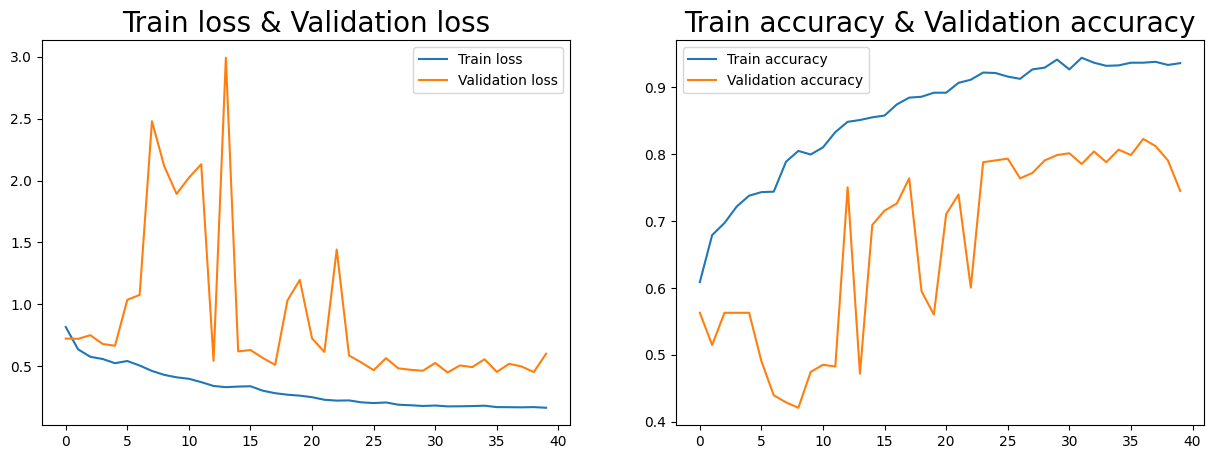

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(df["loss"],label="Train loss")
plt.plot(df["val_loss"],label="Validation loss")
plt.title("Train loss & Validation loss",fontsize=20)
plt.legend()

plt.subplot(1,2,2)
plt.plot(df["accuracy"],label="Train accuracy")
plt.plot(df["val_accuracy"],label="Validation accuracy")
plt.title("Train accuracy & Validation accuracy",fontsize=20)
plt.legend()

# Predictions

Of course prediction are made on knowed data (val_data), in real life that should not be the case. I was just jsut lazy to find 10+ images like this on Google. The goal is just to show that it works.

## Results

In [ ]:
x_val=[] # images
y_val=[] # labels

for image, label in val_data:
    x_val.extend(image.numpy())
    y_val.extend(label.numpy())

# Predictions
predictions=model.predict(np.array(x_val))
print(predictions)
y_pred = np.argmax(predictions, axis=1) # Choosed softmax so i have to select the highest probabilty (good / defective) for each prediction)

plt.figure(figsize=(25, 25),tight_layout=True, facecolor="white")

for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(x_val[i].astype("uint8"))
    actual_label = class_names[y_val[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color ="green"
    else:
        label_color = "red"

    plt.title(f"Actual: {actual_label} \n Predicted: {predicted_label}", color=label_color,fontsize=20)
    plt.axis("off")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Additionnal visualisations

F1 score:[0.7451910976881315]
Precision:[0.7600788781770378]
Recall:[0.7634655223438886]
Classification report
-----------------------
              precision    recall  f1-score   support

           0       0.87      0.64      0.74       210
           1       0.66      0.88      0.75       163

    accuracy                           0.75       373
   macro avg       0.76      0.76      0.75       373
weighted avg       0.78      0.75      0.74       373

Confusion matrix
----------------------


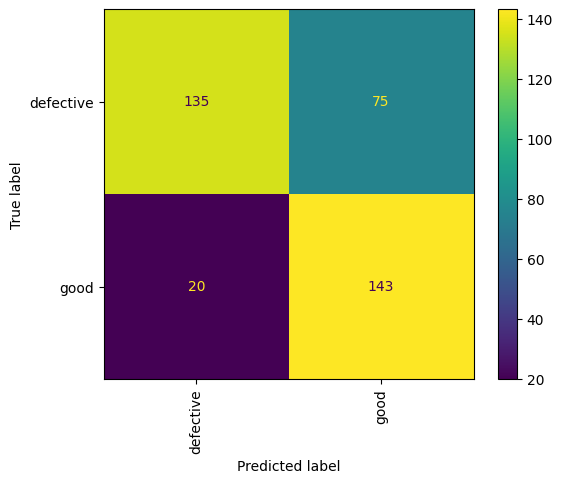

In [ ]:
f1_scores = []
precision_scores = []
recall_scores = []

f1_scores.append(f1_score(y_pred, y_val, average="macro"))
precision_scores.append(precision_score(y_pred, y_val, average="macro"))
recall_scores.append(recall_score(y_pred, y_val, average="macro"))

# Results
print(f"F1 score:{f1_scores}")
print(f"Precision:{precision_scores}")
print(f"Recall:{recall_scores}")

print("Classification report")
print("-----------------------")
print(classification_report(y_val,y_pred))
print("Confusion matrix")
print("----------------------")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=class_names, xticks_rotation="vertical")
plt.show()

In [ ]:
model_name = ["My enhanced CNN model"]
result_df = pd.DataFrame({"F1 score":f1_scores, "Precision score":precision_scores, "Recall score":recall_scores}, index=model_name)
result_df = result_df.T.sort_values(by="My enhanced CNN model", ascending=False)
result_df

,My enhanced CNN model
Recall score,0.763466
Precision score,0.760079
F1 score,0.745191
